## Library and Data Imports

In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# read local csv files and put into data frames
data_url = '17zpallnoagi.csv'
zpallnoagi_csv = pd.read_csv(data_url)
raw_tax_df = pd.DataFrame(zpallnoagi_csv)
mhi_data_url = 'MarketHealthIndex_Zip.csv'
market_health_csv = pd.read_csv(mhi_data_url, on_bad_lines='skip', encoding = "ISO-8859-1")
market_health_df = pd.DataFrame(market_health_csv)

## Data Cleaning and Imputation

### Downselection of Features

In [3]:
# Columns used for both data sets
market_health_cols = ['RegionName','MarketHealthIndex','SellForGain','ForeclosureRatio','NegativeEquity','Delinquency',
                      'DaysOnMarket','ZHVI']

zip_tax_cols = ['N1','ZIPCODE','MARS1','MARS2','MARS4','NUMDEP','A00100','N02650', 'A02650','A00200','A00300', 'A00900',
                'A01000','A01700','SCHF','A02300','A02500','N26270','N03220','A03300','N03150','N03210','N03230',
                'A17000','A18425','A18500','A19300','N19570','A19700','A20950','N04800','A04800','A07300','N07180',
                'A07180','N07220','A07220','N09400','A09400','A10600','N11070','A11070','N06500','A06500','A85300']

# filtered and merged together raw data sets 
tax_zip_df = raw_tax_df.filter(zip_tax_cols)
mh_df = market_health_df.filter(market_health_cols, axis=1)
merged_df = pd.merge(tax_zip_df, mh_df, left_on="ZIPCODE", right_on="RegionName")
grouped_df = merged_df.drop(columns=['RegionName'])

# Print the length of the tax_zip_df and mh_df
print("Length of tax_zip_df: ", len(tax_zip_df))
print("Length of mh_df: ", len(mh_df))
print("Length of merged_df: ", len(merged_df))

# most simpliest data frame with zipcode as the key and all other columns as features
display(grouped_df.head())

Length of tax_zip_df:  27760
Length of mh_df:  14089
Length of merged_df:  14003


,N1,ZIPCODE,MARS1,MARS2,MARS4,NUMDEP,A00100,N02650,A02650,A00200,...,N06500,A06500,A85300,MarketHealthIndex,SellForGain,ForeclosureRatio,NegativeEquity,Delinquency,DaysOnMarket,ZHVI
0,5130.0,35004,2140.0,2120.0,780.0,3350.0,289966.0,5130.0,292671.0,236776.0,...,3870.0,27796.0,32.0,4.893179,NaN,NaN,0.092712,0.026738,76.0,147100.0
1,3170.0,35005,1350.0,870.0,900.0,2230.0,124916.0,3170.0,125810.0,102620.0,...,2010.0,9187.0,0.0,0.887927,40.00,2.9443,0.250780,0.082988,80.0,75000.0
2,1210.0,35006,440.0,580.0,170.0,820.0,59411.0,1210.0,59725.0,46012.0,...,870.0,5089.0,0.0,6.796082,NaN,NaN,0.221277,0.019231,84.0,78500.0
3,11930.0,35007,4720.0,5180.0,1790.0,8840.0,706211.0,11930.0,714402.0,555765.0,...,8520.0,72973.0,90.0,5.600114,84.62,0.6175,0.066375,0.037618,55.0,157700.0
4,7890.0,35010,3000.0,2710.0,2060.0,5850.0,387333.0,7890.0,391523.0,262452.0,...,4740.0,37697.0,688.0,6.150898,NaN,NaN,0.192933,0.017442,147.0,105300.0


### Splitting Training and Holdout Data

Only training data will be used for Exploratory Data Analysis

In [4]:
# splitting data 
# df_eda is 80% of random data, df_holdout is 20% of the remaining data
df_eda, df_holdout = train_test_split(grouped_df, test_size=0.20, random_state=22)
display(df_eda.head())

,N1,ZIPCODE,MARS1,MARS2,MARS4,NUMDEP,A00100,N02650,A02650,A00200,...,N06500,A06500,A85300,MarketHealthIndex,SellForGain,ForeclosureRatio,NegativeEquity,Delinquency,DaysOnMarket,ZHVI
9140,9940.0,13850,4710.0,4340.0,710.0,5100.0,806571.0,9940.0,818461.0,517408.0,...,7780.0,113416.0,916.0,2.586415,81.82,NaN,0.101289,0.066667,92.0,128500.0
5412,3550.0,20616,1690.0,920.0,800.0,2500.0,238866.0,3550.0,239927.0,202262.0,...,2740.0,23869.0,15.0,5.138051,100.00,NaN,0.244229,0.097561,93.5,263200.0
5885,3480.0,1566,1640.0,1540.0,240.0,1790.0,315416.0,3480.0,318920.0,233627.0,...,2880.0,46088.0,189.0,6.323373,100.00,NaN,0.085440,0.081633,76.0,274200.0
4476,13410.0,46815,6620.0,4850.0,1710.0,7980.0,659101.0,13410.0,666299.0,489028.0,...,9400.0,61711.0,161.0,2.110867,NaN,NaN,0.057726,0.047138,49.0,117400.0
12991,24430.0,23223,13650.0,3550.0,6570.0,14020.0,1010689.0,24430.0,1021980.0,844452.0,...,15710.0,99345.0,183.0,2.631840,76.47,6.3815,0.163589,0.034208,63.0,140900.0


### Normalizing by Count

In [5]:
n1_url = 'Columns_Used.csv'
Columns_Used = pd.read_csv(n1_url)
Columns_Used[Columns_Used['Description'].str.contains("Number of")]
column_list = list(Columns_Used.Code)
column_list = [x.strip() for x in column_list]

for column in column_list:
    if column != "N1" and column in list(df_eda.columns):
        df_eda[column] = df_eda[column].div(df_eda["N1"])
        

### Imputation of Missing Values

In [6]:
# First remove rows missing the target variable of ZHVI
df_eda = df_eda[df_eda['ZHVI'].notna()]

# Split the data into input and target
train_X = df_eda.drop(columns=['ZHVI'])
train_y = df_eda['ZHVI']

# Calculating the missing values
missing_values = train_X.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Creating datafram to display missing data
cols = ['Feature', 'Number Missing', 'Percent Missing']
missing_df = pd.DataFrame(columns=cols)
for col in missing_values.index:
    missing_df.loc[len(missing_df.index)] = {'Feature': col,
                                    'Number Missing': missing_values[col],
                                    'Percent Missing': missing_values[col] / len(df_eda) * 100}

pd.set_option('display.float_format', '{:.1f}'.format)
display(missing_df)

# Remove SellForGain, ForeclosureRatio columns
#train_X = train_X.drop(columns=['SellForGain', 'ForeclosureRatio'])

# Impute missing values using KNN
imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(train_X)

# Convert the numpy array back into a dataframe
train_X = pd.DataFrame(imputed_values, columns=train_X.columns)

missing_values_after = train_X.isnull().sum()
print('\nTotal missing values after imputation:')
print(len(missing_values_after[missing_values_after > 0]))

,Feature,Number Missing,Percent Missing
0,SellForGain,3645,32.9
1,ForeclosureRatio,8581,77.4
2,NegativeEquity,295,2.7
3,Delinquency,295,2.7
4,DaysOnMarket,107,1.0



Total missing values after imputation:
0


## Exploratory Data Analysis

### Distribution of Key Features and Target Variable

Range of total tax income $20.35 - $1730.42
Range of total Zillow's Housing Value Index $32700.00 - $6421400.00


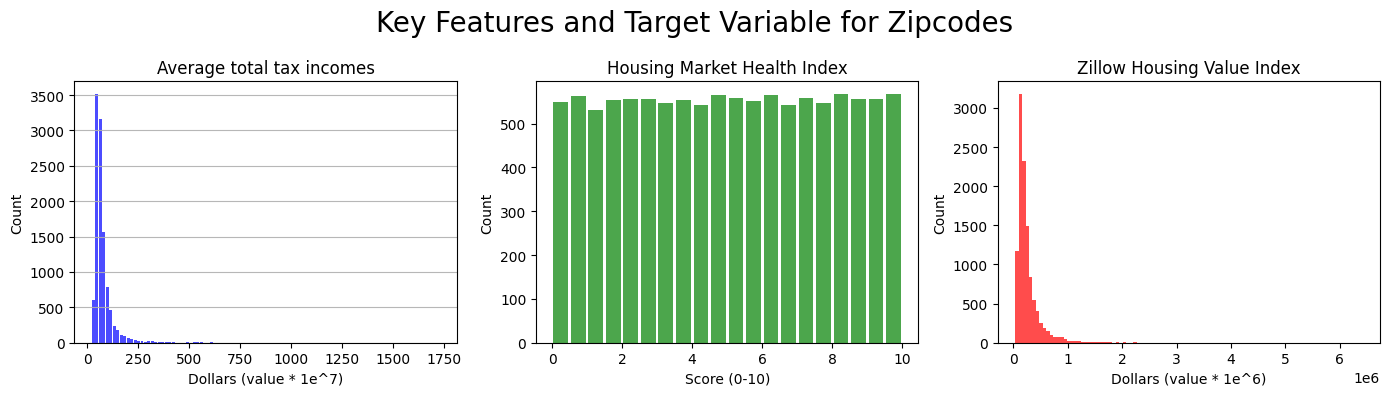

In [7]:
fig, axs = plt.subplots(1,3, figsize=(14,4))

axs[0].ticklabel_format(axis='both')

print(f"Range of total tax income ${min(df_eda['A02650']):.2f} - ${max(df_eda['A02650']):.2f}")
# Create a histogram for 'income'
axs[0].hist(df_eda['A02650'], bins=100, color='blue', alpha=0.7, rwidth=0.85)
axs[0].grid(axis='y', alpha=0.9)
axs[0].set_title('Average total tax incomes')
axs[0].set_xlabel('Dollars (value * 1e^7)')
axs[0].set_ylabel('Count')

# Create a histogram for 'market_health_index'
axs[1].hist(df_eda['MarketHealthIndex'], bins=20, color='green', alpha=0.7, rwidth=0.85)
axs[1].set_title('Housing Market Health Index')
axs[1].set_xlabel('Score (0-10)')
axs[1].set_ylabel('Count')

print(f"Range of total Zillow's Housing Value Index ${min(df_eda['ZHVI']):.2f} - ${max(df_eda['ZHVI']):.2f}")
# Create a histogram for 'zillow_housing_value_index'
axs[2].hist(df_eda['ZHVI'], bins=100, color='red', alpha=0.7)
axs[2].set_title('Zillow Housing Value Index')
axs[2].set_xlabel("Dollars (value * 1e^6)")
axs[2].set_ylabel("Count")

fig.suptitle('Key Features and Target Variable for Zipcodes', fontsize=20)

plt.tight_layout()

### Viewing Boxplots

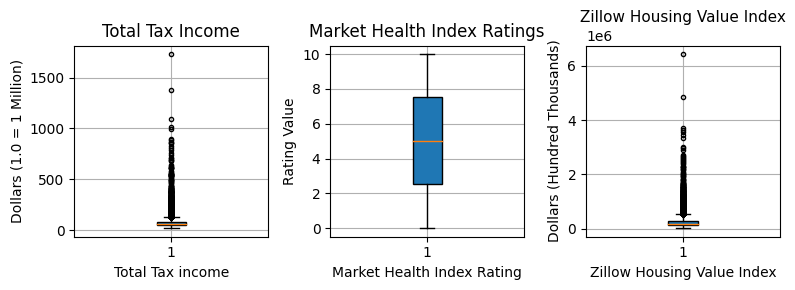

In [8]:
# Showing quartile ranges on total tax income
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(8,3))
income_mean = np.mean(df_eda['A02650'].values)
ax1.boxplot(df_eda['A02650'], sym='.', patch_artist=True)
# ax1.axhline(y = income_mean, color = 'r', linestyle = '-')
ax1.grid(True)
ax1.set_title("Total Tax Income")
ax1.set_xlabel("Total Tax income")
ax1.set_ylabel("Dollars (1.0 = 1 Million)")

# Plotting and labeling MarketHealthIndex boxplot graph 
ax2.boxplot(df_eda['MarketHealthIndex'], sym='.', patch_artist=True)
ax2.grid(True)
ax2.set_title("Market Health Index Ratings")
ax2.set_xlabel("Market Health Index Rating")
ax2.set_ylabel("Rating Value")

# Plotting and labeling Zillow Housing Value Index boxplot
ax3.boxplot(df_eda['ZHVI'], sym='.', patch_artist=True)
ax3.grid(True)
ax3.set_title("Zillow Housing Value Index", fontsize="11")
ax3.set_xlabel("Zillow Housing Value Index")
ax3.set_ylabel("Dollars (Hundred Thousands)")

plt.tight_layout()

### Data Loss from Dataset Merge

In [9]:
available_returns = raw_tax_df.groupby(['STATE']).sum().reset_index()
market_health_zips = market_health_df['RegionName'].tolist()


used_returns = raw_tax_df[raw_tax_df['ZIPCODE'].isin(market_health_zips)]

used_returns = used_returns.groupby(['STATE']).sum().reset_index()


merged_df = pd.merge(available_returns, used_returns, on='STATE', how='inner')

merged_df['Ratio'] = merged_df['N1_y'] / merged_df['N1_x']

import plotly.express as px

# May need pip install --upgrade nbformat

fig = px.choropleth(merged_df, locations="STATE", color="Ratio", hover_name="STATE", 
                    title='Percentage Use of Zip Codes by State', locationmode='USA-states', scope='usa', color_continuous_scale="Viridis")
fig.show()


## Model Selection

### Final Data Preparation

Split holdout into validation and train sets and perform same data cleaning as training values.
Normalize all inputs. 

In [10]:
# Remove rows missing the target variable of ZHVI
df_holdout = df_holdout[df_holdout['ZHVI'].notna()]

# Split holdout data into validation and test set
val, test = train_test_split(df_holdout, test_size=0.50, random_state=22)

# Split the data into input and target
val_X = val.drop(columns=['ZHVI'])
val_y = val['ZHVI']

test_X = test.drop(columns=['ZHVI'])
test_y = test['ZHVI']

val_imputed_values = imputer.fit_transform(val_X)
test_imputed_values = imputer.fit_transform(test_X)

# Convert the numpy array back into a dataframe
val_X = pd.DataFrame(val_imputed_values, columns=val_X.columns)
test_X = pd.DataFrame(test_imputed_values, columns=test_X.columns)

# Divide by N1 value
n1_url = 'Columns_Used.csv'
Columns_Used = pd.read_csv(n1_url)
Columns_Used[Columns_Used['Description'].str.contains("Number of")]
column_list = list(Columns_Used.Code)
column_list = [x.strip() for x in column_list]

for column in column_list:
    if column != "N1" and column in list(val_X.columns):
        val_X[column] = val_X[column].div(val_X["N1"])
        test_X[column] = test_X[column].div(test_X["N1"])

# Calculating the missing values
missing_values = test_X.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Creating datafram to display missing data
cols = ['Feature', 'Number Missing', 'Percent Missing']
missing_df = pd.DataFrame(columns=cols)
for col in missing_values.index:
    missing_df.loc[len(missing_df.index)] = {'Feature': col,
                                    'Number Missing': missing_values[col],
                                    'Percent Missing': missing_values[col] / len(df_eda) * 100}

pd.set_option('display.float_format', '{:.1f}'.format)
display(missing_df)
        
# Scale with MinMaxScaler
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train_X)
train_X_min_max = min_max_scaler.transform(train_X)
val_X_min_max = min_max_scaler.transform(val_X)
test_X_min_max = min_max_scaler.transform(test_X)


# Normalize the train_X data
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)

# Normalize the val_X and test_X data
val_X = scaler.transform(val_X.to_numpy())
test_X = scaler.transform(test_X.to_numpy())


,Feature,Number Missing,Percent Missing


/Users/kdevoe/Documents/CS/Masters/AAI500/FInal_Project/aai-500-final-group-4/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/Users/kdevoe/Documents/CS/Masters/AAI500/FInal_Project/aai-500-final-group-4/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



Function to analzye results of a given regression model for price prediction.

In [11]:
def analyze_results(actual, predictions, name=""):

    print(actual)
    interval_size = 100
    last_interval = 1000
    num_intervals = int(last_interval / interval_size)

    results_df = pd.DataFrame(columns=['Interval', 'Count', 'RMSE', 'Max_Difference'])

    # Process each interval for value
    for i in range(0, num_intervals):

        filtered_actual = []
        filtered_predictions = []
        
        # Filter the actual and predictions to the current interval
        lower_bound = interval_size * i * 1000

        if i == num_intervals - 1:
            upper_bound = np.inf
        else:
            upper_bound = interval_size * (i + 1) * 1000

        for j in range(len(actual)):
            if actual[j] >= lower_bound and actual[j] < upper_bound:
                filtered_actual.append(actual[j])
                filtered_predictions.append(predictions[j])

        # Calculate the metrics for the interval
        rmse = np.sqrt(mean_squared_error(filtered_actual, filtered_predictions))
        max_diff = 0
        for j in range(len(filtered_actual)):
            max_diff = max(abs(filtered_actual[j] - filtered_predictions[j]), max_diff)

        lower = f'${lower_bound / 1000}k'
        if upper_bound == np.inf:
            upper = 'Maximum'
        else:
            upper = f'${upper_bound / 1000}k'
        # Store interval results
        results_df.loc[len(results_df.index)] = {'Interval': f'{lower} to {upper}',
                                                  'Count': len(filtered_actual),
                                                  'RMSE': rmse, 
                                                  'Max_Difference': max_diff}

    # Add the final row for all data
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    max_diff = 0
    for j in range(len(actual)):
        max_diff = max(abs(actual[j] - predictions[j]), max_diff)
    results_df.loc[len(results_df.index)] = {'Interval': 'All Data',
                                                'Count': len(actual),
                                                'RMSE': rmse,
                                                'Max_Difference': max_diff}
        
    # Plot the results
    plt.scatter(actual, predictions, color='blue')
    plt.title(f'{name} Results')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # Add a line for perfect correlation
    min_value = min(min(actual), min(predictions))
    max_value = max(max(actual), max(predictions))
    plt.plot([min_value, max_value], [min_value, max_value], color='red')
    # Add legend
    plt.legend(['Model Results', 'Perfect Correlation'])

    plt.show()

    return results_df

### Linear Regression

Validation results:
[ 89700. 552800. 176300. ... 127300. 306400. 133100.]


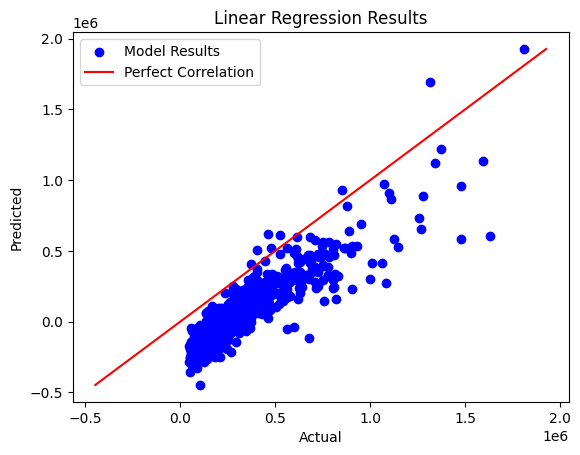

,Interval,Count,RMSE,Max_Difference
0,$0.0k to $100.0k,169,271913.5,412205.5
1,$100.0k to $200.0k,575,261567.2,553146.8
2,$200.0k to $300.0k,315,250781.2,486521.1
3,$300.0k to $400.0k,131,247165.8,409475.7
4,$400.0k to $500.0k,73,249220.0,436186.6
5,$500.0k to $600.0k,38,311030.6,632751.2
6,$600.0k to $700.0k,30,318626.7,792107.6
7,$700.0k to $800.0k,22,362389.2,609121.6
8,$800.0k to $900.0k,14,414237.8,659050.4
9,$900.0k to Maximum,25,532037.2,1025326.9


In [12]:
# Running linear regression with a constant on test set
model = sm.OLS(train_y.values, train_X)
results = model.fit()

# Using model to predict on our validation set and to compare predict values
predict_val = results.predict(val_X)

print('Validation results:')
display(analyze_results(val_y.values, predict_val, "Linear Regression"))

## Generalized Linear Models

[ 89700. 552800. 176300. ... 127300. 306400. 133100.]


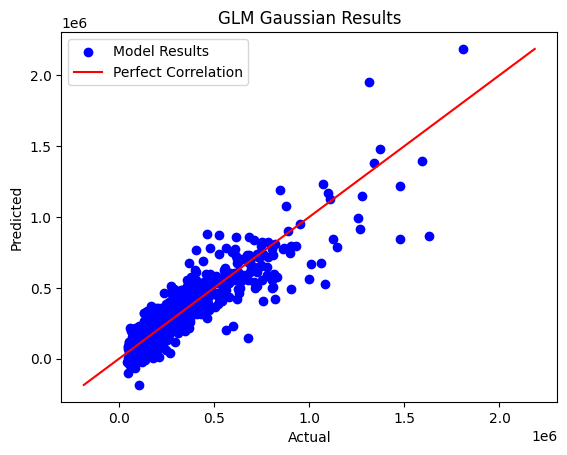

,Interval,Count,RMSE,Max_Difference
0,$0.0k to $100.0k,169,54761.1,157885.7
1,$100.0k to $200.0k,575,53979.2,289414.0
2,$200.0k to $300.0k,315,67431.4,239589.4
3,$300.0k to $400.0k,131,80433.1,302077.6
4,$400.0k to $500.0k,73,108900.2,419389.7
5,$500.0k to $600.0k,38,134325.1,369244.4
6,$600.0k to $700.0k,30,140095.5,531644.1
7,$700.0k to $800.0k,22,140717.5,348224.7
8,$800.0k to $900.0k,14,223111.5,400643.2
9,$900.0k to Maximum,25,352097.7,763736.8


/Users/kdevoe/Documents/CS/Masters/AAI500/FInal_Project/aai-500-final-group-4/env/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning:

The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.

/Users/kdevoe/Documents/CS/Masters/AAI500/FInal_Project/aai-500-final-group-4/env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:307: DomainWarning:

The identity link function does not respect the domain of the Gamma family.



[ 89700. 552800. 176300. ... 127300. 306400. 133100.]


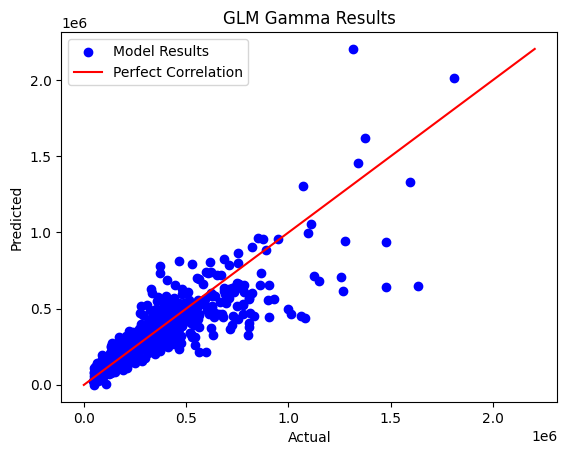

,Interval,Count,RMSE,Max_Difference
0,$0.0k to $100.0k,169,30192.7,109049.2
1,$100.0k to $200.0k,575,33874.8,143844.9
2,$200.0k to $300.0k,315,50028.7,242136.8
3,$300.0k to $400.0k,131,93307.8,406866.1
4,$400.0k to $500.0k,73,105710.6,349132.3
5,$500.0k to $600.0k,38,150158.6,385822.1
6,$600.0k to $700.0k,30,144080.8,302136.0
7,$700.0k to $800.0k,22,197070.5,352957.2
8,$800.0k to $900.0k,14,278715.3,477259.7
9,$900.0k to Maximum,25,493915.6,983295.3


In [13]:
# Instantiate a Gaussian family model with the default link function.
# Testing test set
glm_gaus = sm.GLM(train_y.values, train_X_min_max, family=sm.families.Gaussian())
res_gaus = glm_gaus.fit()
predict_glm_train = res_gaus.predict()
MSE = mean_squared_error(train_y, predict_glm_train)
sMSE_gaus_train = np.sqrt(MSE)


# Testing on Validation set
predict_glm_val = res_gaus.predict(val_X_min_max)
MSE = mean_squared_error(val_y, predict_glm_val)
sMSE_gaus_val = np.sqrt(MSE)

display(analyze_results(val_y.values, predict_glm_val, "GLM Gaussian"))

# Instantiate a gamma family model with the default link function.
# Test set
glm_gamma = sm.GLM(train_y.values, train_X_min_max , family=sm.families.Gamma(link=sm.genmod.families.links.identity()))
res_gamma = glm_gamma.fit()
predict_glm_gamma_train = res_gamma.predict()
MSE = mean_squared_error(train_y, predict_glm_gamma_train)
sMSE_gamma_train = np.sqrt(MSE)

# For validation set
predict_glm_gamma_val = res_gamma.predict(val_X_min_max)
MSE = mean_squared_error(val_y, predict_glm_gamma_val)
sMSE_gamma_val = np.sqrt(MSE)

display(analyze_results(val_y.values, predict_glm_gamma_val, "GLM Gamma"))

### XGBoost Evaluation

Val y  [ 89700. 552800. 176300. ... 127300. 306400. 133100.]
Predicted  [ 84024.26 588563.2  164197.73 ... 163721.89 297872.88 138215.77]
[ 89700. 552800. 176300. ... 127300. 306400. 133100.]


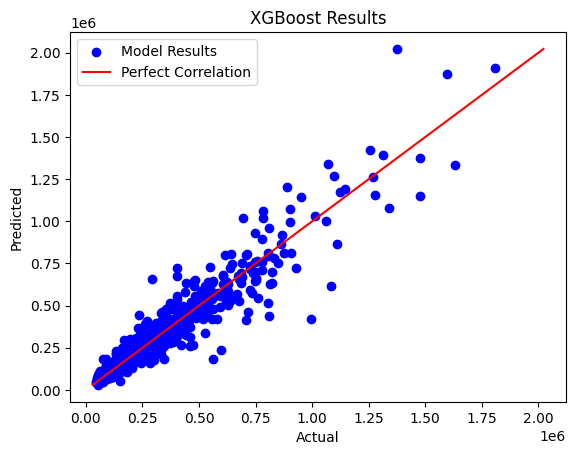

,Interval,Count,RMSE,Max_Difference
0,$0.0k to $100.0k,169,21462.3,106746.7
1,$100.0k to $200.0k,575,24365.9,127943.8
2,$200.0k to $300.0k,315,42257.2,365805.9
3,$300.0k to $400.0k,131,54280.0,160963.2
4,$400.0k to $500.0k,73,91172.6,321746.4
5,$500.0k to $600.0k,38,113522.7,380006.2
6,$600.0k to $700.0k,30,100812.1,327768.2
7,$700.0k to $800.0k,22,146740.0,295872.4
8,$800.0k to $900.0k,14,178449.7,370654.9
9,$900.0k to Maximum,25,259402.3,648382.9


In [14]:
from xgboost import XGBRegressor

model = XGBRegressor()

# fit the model on the whole dataset
model.fit(train_X, train_y.values)

# make a single prediction
predict_xgboost_val = model.predict(val_X)

print('Val y ', val_y.values)
print('Predicted ', predict_xgboost_val)

display(analyze_results(val_y.values, predict_xgboost_val, 'XGBoost'))

### Sequential Neural Network Evaluation

In [15]:
# Constants

BATCH_SIZE = 1
EPOCHS = 10
LR = 0.01

In [16]:
# Model definition
class Model(nn.Module):
    def __init__(self, input_size, output_size=1):
        super().__init__()

        self.hidden_dim = output_size + (input_size - output_size) // 2

        self.fc_1 = nn.Linear(input_size, self.hidden_dim)
        self.fc_2 = nn.Linear(self.hidden_dim, output_size)

    def forward(self, x):

        out = self.fc_1(x)
        out = F.relu(out)
        out = self.fc_2(out)

        return out

neural_model = Model(train_X.shape[1])
print(neural_model)

Model(
  (fc_1): Linear(in_features=51, out_features=26, bias=True)
  (fc_2): Linear(in_features=26, out_features=1, bias=True)
)


Run on GPU if available

In [17]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")

else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

neural_model.to(device)

GPU not available, CPU used


Model(
  (fc_1): Linear(in_features=51, out_features=26, bias=True)
  (fc_2): Linear(in_features=26, out_features=1, bias=True)
)

In [18]:
# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(neural_model.parameters(), lr=LR)


In [19]:
# Training loop

def training_loop(model, train_X, train_y, val_X, val_y, num_epochs = 1, batch_size = 1):

    num_batches = len(train_X) // batch_size

    train_losses = []
    val_losses = []
    total_loss = 0

    for epoch in tqdm(range(num_epochs)):  # loop over the dataset for each epoch
        for batch in range(num_batches):
            # get the inputs; data is a list of [inputs, labels]
            start_index = batch * batch_size
            end_index = start_index + batch_size
            inputs = torch.from_numpy(train_X[start_index: end_index]).float().reshape(batch_size, -1)
            inputs.requires_grad = True
            labels = torch.from_numpy(np.asarray(train_y[start_index: end_index])).float().reshape(batch_size, -1)
            labels.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, labels))
            loss.backward()
            optimizer.step()

            total_loss += np.mean(loss.item())

        # Get the validation losses
        val_outputs = model(torch.from_numpy(val_X).float().reshape(len(val_X), -1))
        val_loss = torch.sqrt(criterion(val_outputs, torch.from_numpy(np.asarray(val_y)).float().reshape(len(val_y), -1)))

        average_loss = total_loss / num_batches
        train_losses.append(average_loss)
        val_losses.append(val_loss.detach().numpy())
        total_loss = 0  # Reset the total loss for the next epoch
        
    return train_losses, val_losses

100%|██████████| 10/10 [00:29<00:00,  2.96s/it]


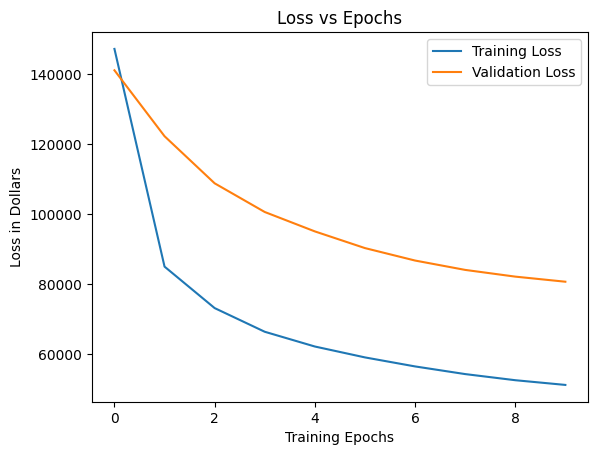

y values [ 89700. 552800. 176300. ... 127300. 306400. 133100.]
outputs [[113968.68]
 [619216.25]
 [120232.84]
 ...
 [132472.34]
 [308739.2 ]
 [198712.12]]
val_outputs [113968.6796875, 619216.25, 120232.84375, 337901.6875, 119932.8359375, 601780.625, 216929.53125, 196923.09375, 144779.234375, 311493.375, 406011.0625, 105059.0703125, 301473.375, 73860.3046875, 85539.7578125, 295671.59375, 140042.9375, 103608.53125, 440280.78125, 98542.3359375, 91891.8359375, 339249.5625, 205010.734375, 180753.65625, 219797.6875, 320692.3125, 380963.8125, 289932.21875, 113575.8359375, 152448.921875, 501435.9375, 246408.046875, 191649.421875, 566707.375, 152081.0, 60127.25, 106306.1328125, 78120.5390625, 298471.28125, 311927.5, 194156.375, 116444.40625, 120945.4609375, 99976.5703125, 113834.6640625, 186400.96875, 67869.0234375, 208546.4375, 123651.671875, 152007.875, 108730.2890625, 286078.4375, 491390.6875, 158590.28125, 489745.90625, 132502.75, 353589.1875, 665010.1875, 103088.203125, 139179.03125, 70547

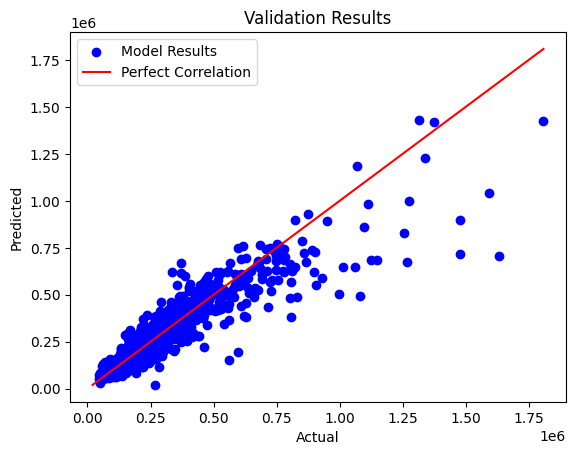

              Interval  Count     RMSE  Max_Difference
0     $0.0k to $100.0k    169  23437.5         72597.2
1   $100.0k to $200.0k    575  28270.8        145854.5
2   $200.0k to $300.0k    315  49701.5        248244.5
3   $300.0k to $400.0k    131  75745.5        297646.9
4   $400.0k to $500.0k     73  78525.3        240925.4
5   $500.0k to $600.0k     38 126204.5        406670.0
6   $600.0k to $700.0k     30 108122.2        245983.1
7   $700.0k to $800.0k     22 115854.1        278128.4
8   $800.0k to $900.0k     14 217007.9        426706.2
9   $900.0k to Maximum     25 429248.3        926255.8
10            All Data   1392  80627.7        926255.8


In [20]:
train_losses, val_losses = training_loop(neural_model, train_X, train_y, val_X, val_y, num_epochs=EPOCHS, batch_size=BATCH_SIZE)

# Get predictions on the validation set
val_outputs = neural_model(torch.from_numpy(val_X).float().reshape(len(val_X), -1))
val_outputs = val_outputs.detach().numpy()

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Loss in Dollars')
plt.legend()

plt.show()

print('y values', val_y.values)
print('outputs', val_outputs)

# Convert numpy ndarray to list
val_outputs = val_outputs.tolist()
val_outputs = [item for sublist in val_outputs for item in sublist]

print('val_outputs', val_outputs)

print(analyze_results(val_y.values, val_outputs, "Validation"))
